In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
from strategy_signal import trend_following_expanded_universe as tf_exp
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(tf_exp)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [10]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [12]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

In [14]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [16]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD',
   'ICP-USD',
   'CRO-USD',
   'XTZ-USD',
   'FIL-USD',
   'LINK-USD',
   'FET-USD',
   'GRT-USD',
   'OXT-USD',
   'KRL-USD'],
  'sleeves': {'L1_Core': {'weight': 0.5,
    'tickers': ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD']},
   'L1_Alt': {'weight': 0.15,
    'tickers': ['ICP-USD', 'CRO-USD', 'XTZ-USD', 'FIL-USD']},
   'AI': {'weight': 0.35,
    'tickers': ['LINK-USD', 'FET-USD', 'GRT-USD', 'OXT-USD', 'KRL-USD']}}},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_t

## Debug Prod Configuration

In [20]:
import datetime
from datetime import datetime, timezone, timedelta
from typing import Iterable
import argparse
import json
import traceback
import itertools
import ast
from strategy_signal.trend_following_signal import (
    get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from utils import stop_loss_cooldown_state as state
from strategy_signal import trend_following_signal as tf
from pathlib import Path
import yaml
import uuid
# from trend_following_email_summary_v020 import send_summary_email

In [22]:
import sys
import importlib.util
from pathlib import Path

strategy_path = Path("/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/trend_following_v0.2.0-live.py").resolve()
sys.path.insert(0, str(strategy_path.parent))

spec = importlib.util.spec_from_file_location("trend_following_v0_2_0_live", strategy_path)
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)

# now access functions/classes
# mod.some_function(...)

In [24]:
STATE_DIR = Path("/Users/adheerchauhan/Documents/live_strategy_logs/trend_following_v0_2_0-live")
STATE_DIR.mkdir(parents=True, exist_ok=True)
COOLDOWN_STATE_FILE = STATE_DIR / "stop_loss_breach_cooldown_state.json"
COOLDOWN_LOG_FILE   = STATE_DIR / "stop_loss_breach_cooldown_log.jsonl"
DONE_FLAG_DIR       = STATE_DIR / "done_flags"
RUN_LOG             = STATE_DIR / "live_run.log"

# Ensure subdirectories exist
DONE_FLAG_DIR.mkdir(parents=True, exist_ok=True)

# JSONL log files
LIVE_ERRORS_LOG       = STATE_DIR / "live_errors.jsonl"
HEARTBEAT_LOG         = STATE_DIR / "heartbeat.jsonl"
DESIRED_TRADES_LOG    = STATE_DIR / "desired_trades_log.jsonl"
ORDER_BUILD_LOG       = STATE_DIR / "order_build_log.jsonl"
ORDER_SUBMIT_LOG      = STATE_DIR / "order_submit_log.jsonl"
DUST_BUILD_LOG        = STATE_DIR / "dust_build_log.jsonl"
DUST_SUBMIT_LOG       = STATE_DIR / "dust_submit_log.jsonl"
STOP_UPDATE_LOG       = STATE_DIR / "stop_update_log.jsonl"
DAILY_SUMMARY_DIR = STATE_DIR / "daily_summaries"
DAILY_SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

CURRENT_RUN_ID = None

def new_run_id(now_utc=None) -> str:
    now_utc = now_utc or utc_now()
    return now_utc.strftime("%Y-%m-%dT%H%M%SZ") + "-" + uuid.uuid4().hex[:8]

def set_run_id(run_id: str):
    global CURRENT_RUN_ID
    CURRENT_RUN_ID = run_id

def daily_summary_path(day) -> Path:
    return DAILY_SUMMARY_DIR / f"daily_summary_{day.isoformat()}.json"


def utc_now():
    return datetime.now(timezone.utc)


def _utc_ts(d):
    """UTC tz-aware Timestamp (00:00Z if 'd' is a date)."""
    ts = pd.Timestamp(d)
    return ts.tz_localize('UTC') if ts.tzinfo is None else ts.tz_convert('UTC')


def utc_now_iso():
    return datetime.now(timezone.utc).isoformat()


def parse_args():
    ap = argparse.ArgumentParser()
    ap.add_argument("--force-run", action="store_true")
    ap.add_argument("--run-at-utc-hour", type=int, default=0)
    ap.add_argument("--gate-minutes", type=int, default=5)
    ap.add_argument("--dry-run", action="store_true")

    return ap.parse_args()

In [309]:
# args = parse_args()
now = utc_now()
today = now.date()

# Generate Run Id for the run and log start time
run_id = new_run_id(now)
set_run_id(run_id)
started_at = utc_now_iso()
run_errors = []
stop_results = {}

In [28]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')
portfolio_name = cfg['portfolio']['name']
ticker_list = cfg['universe']['tickers']
sleeve_budgets = cfg['universe']['sleeves']
min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']
passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']
highest_high_window = cfg['risk_and_sizing']['highest_high_window']
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [30]:
## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve

In [32]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
_ = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)  # validate

In [311]:
date = today

In [313]:
today

datetime.date(2026, 1, 29)

In [38]:
df, desired_positions, current_positions = mod.get_desired_trades_by_ticker(client, cfg, date=today)

Generating Volatility Adjusted Trend Signal!!
Covariance Matrix Time: 2026-01-27 06:44:48.491775
Start Time: 2026-01-27 06:44:48.521801
Get Portfolio Equity and Cash Time: 2026-01-27 06:44:48.626654
Get Current Positions Time: 2026-01-27 06:44:48.940398
Target Volatility Position Sizing Time: 2026-01-27 06:45:03.065316


In [42]:
current_positions

{'BTC-USD': {'ticker_qty': 0,
  'ticker_mid_price': 87924.035,
  'ticker_current_notional': 0.0},
 'ETH-USD': {'ticker_qty': 0,
  'ticker_mid_price': 2915.295,
  'ticker_current_notional': 0.0},
 'SOL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 123.93,
  'ticker_current_notional': 0.0},
 'ADA-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.35045,
  'ticker_current_notional': 0.0},
 'AVAX-USD': {'ticker_qty': 0,
  'ticker_mid_price': 11.684999999999999,
  'ticker_current_notional': 0.0},
 'ICP-USD': {'ticker_qty': 0,
  'ticker_mid_price': 3.2575000000000003,
  'ticker_current_notional': 0.0},
 'CRO-USD': {'ticker_qty': 0,
  'ticker_mid_price': 0.090515,
  'ticker_current_notional': 0.0},
 'XTZ-USD': {'ticker_qty': 0.01,
  'ticker_mid_price': 0.5583,
  'ticker_current_notional': 0.005583},
 'FIL-USD': {'ticker_qty': 0,
  'ticker_mid_price': 1.2614999999999998,
  'ticker_current_notional': 0.0},
 'LINK-USD': {'ticker_qty': 0,
  'ticker_mid_price': 11.91,
  'ticker_current_notional': 0.0

In [41]:
desired_positions

{'BTC-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ETH-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'SOL-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ADA-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'AVAX-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ICP-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'CRO-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'XTZ-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'FIL-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'LINK-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'FET-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'GRT-USD': {'new_t

In [90]:
df.tail()

BTC-USD_actual_position_notional  BTC-USD_actual_position_size  \
date                                                                         
2026-01-23                               0.0                           0.0   
2026-01-24                               0.0                           0.0   
2026-01-25                               0.0                           0.0   
2026-01-26                               0.0                           0.0   
2026-01-27                               0.0                           0.0   

            BTC-USD_annualized_volatility_30  BTC-USD_cash_shrink_factor  \
date                                                                       
2026-01-23                          0.310205                         0.0   
2026-01-24                          0.310187                         0.0   
2026-01-25                          0.310051                         0.0   
2026-01-26                          0.326260                         0.0   
2026-01-27                          0.332820                         0.0   

            BTC-USD_close  BTC-USD_cooldown_counter  BTC-USD_data_ok  \
date                                                                   
2026-01-23       89474.93                       0.0              1.0   
2026-01-24       89082.17                       0.0              1.0   
2026-01-25       86561.94                       0.0              1.0   
2026-01-26       88250.01                       0.0              1.0   
2026-01-27       87935.16                       0.0              1.0   

           BTC-USD_event  BTC-USD_final_signal  \
date                                             
2026-01-23          <NA>                   0.0   
2026-01-24          <NA>                   0.0   
2026-01-25          <NA>                   0.0   
2026-01-26          <NA>                   0.0   
2026-01-27          <NA>                   0.0   

            BTC-USD_final_weighted_additive_signal  \
date                                                 
2026-01-23                               -0.137088   
2026-01-24                               -0.138483   
2026-01-25                               -0.141104   
2026-01-26                               -0.162523   
2026-01-27                               -0.162201   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2026-01-23                                    0.0   
2026-01-24                                    0.0   
2026-01-25                                    0.0   
2026-01-26                                    0.0   
2026-01-27                                    0.0   

            BTC-USD_new_position_notional  BTC-USD_open  \
date                                                      
2026-01-23                            0.0      89463.51   
2026-01-24                            0.0      89474.94   
2026-01-25                            0.0      89082.16   
2026-01-26                            0.0      86561.94   
2026-01-27                            0.0      88250.00   

            BTC-USD_open_position_notional  BTC-USD_open_position_size  \
date                                                                     
2026-01-23                             0.0                         0.0   
2026-01-24                             0.0                         0.0   
2026-01-25                             0.0                         0.0   
2026-01-26                             0.0                         0.0   
2026-01-27                             0.0                         0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_sleeve_risk_adj_weights  \
date                                                                       
2026-01-23                          0.0                              0.0   
2026-01-24                          0.0                              0.0   
2026-01-25                          0.0                              0.0   
2026-01-26  

In [44]:
total_buys = sum(1 for t, d in desired_positions.items() if float(d.get("new_trade_notional", 0.0)) > 0)
total_sells = sum(1 for t, d in desired_positions.items() if float(d.get("new_trade_notional", 0.0)) < 0)
total_zero = sum(
    1 for t, d in desired_positions.items() if abs(float(d.get("new_trade_notional", 0.0))) < 1e-9)

In [46]:
print(total_buys, total_sells, total_zero)

0 0 14


In [48]:
rebalance_orders = mod.build_rebalance_orders(desired_positions=desired_positions,
                                              date=today, current_positions=current_positions,
                                              client=client, order_type='market', limit_price_buffer=0.0)

In [50]:
rebalance_orders

[]

In [52]:
sell_products = sorted(
    {o.get("product_id") for o in (rebalance_orders or []) if str(o.get("side", "")).upper() == "SELL"})
for product_id in sell_products:
    if not product_id:
        continue
    cancel_info = cancel_open_stop_orders_for_product(client, product_id, stage="pre_rebalance_sell",
                                                      allow_live=(not bool(args.dry_run)))

In [54]:
sell_products

[]

In [58]:
if rebalance_orders:
    preview_flag = True#bool(args.dry_run)
    try:
        resp = submit_daily_rebalance_orders(client, rebalance_orders, preview=preview_flag)
        # write_jsonl(ORDER_SUBMIT_LOG, {
        #     "ts": utc_now_iso(),
        #     "stage": "rebalance_submit",
        #     "preview": preview_flag,
        #     "orders_count": len(rebalance_orders),
        #     "response": cn._as_dict(resp) if 'resp' in locals() else None
        # })
    except Exception as e:
        err = {"ts": utc_now_iso(), "where": "submit_daily_rebalance_orders",
               "preview": preview_flag, "error": str(e)}
        # write_jsonl(LIVE_ERRORS_LOG, err)
        run_errors.append(err)
        print(f"[warn] rebalance submit failed: {e}", flush=True)

In [64]:
dust_close_orders = mod.build_dust_close_orders(
    client=client, df=df, date=today, ticker_list=ticker_list,
    min_trade_notional_abs=min_trade_notional_abs,
    max_cost_usd=0.05,               # don't spend >$0.05 to clean dust
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    use_ioc=True)

In [66]:
dust_close_orders

[]

In [68]:
dust_sell_products = sorted(
    {o.get("product_id") for o in (dust_close_orders or []) if str(o.get("side", "")).upper() == "SELL"})
for product_id in dust_sell_products:
    if not product_id:
        continue
    cancel_info = mod.cancel_open_stop_orders_for_product(client, product_id, stage="pre_dust_sell",
                                                          allow_live=(not bool(args.dry_run)))
    # write_jsonl(STOP_UPDATE_LOG, {"ts": utc_now_iso(), "stage": "pre_dust_sell_cancel", **cancel_info})

In [70]:
cancel_info

NameError: name 'cancel_info' is not defined

In [72]:
if dust_close_orders:
    preview_flag = True#bool(args.dry_run)
    try:
        resp = submit_dust_close_orders(client=client, orders=dust_close_orders, preview=preview_flag)
        # write_jsonl(DUST_SUBMIT_LOG, {
        #     "ts": utc_now_iso(),
        #     "stage": "dust_submit",
        #     "preview": preview_flag,
        #     "orders_count": len(dust_close_orders),
        #     "response": cn._as_dict(resp) if 'resp' in locals() else None
        # })
    except Exception as e:
        err = {"ts": utc_now_iso(), "where": "submit_dust_close_orders",
               "preview": preview_flag, "error": str(e)}
        # write_jsonl(LIVE_ERRORS_LOG, err)
        run_errors.append(err)
        print(f"[warn] dust submit failed: {e}", flush=True)

In [74]:
df = mod.refresh_df_actual_position_sizes_from_portfolio(client, df, today, ticker_list, portfolio_name)

In [76]:
df.tail()

BTC-USD_actual_position_notional  BTC-USD_actual_position_size  \
date                                                                         
2026-01-23                               0.0                           0.0   
2026-01-24                               0.0                           0.0   
2026-01-25                               0.0                           0.0   
2026-01-26                               0.0                           0.0   
2026-01-27                               0.0                           0.0   

            BTC-USD_annualized_volatility_30  BTC-USD_cash_shrink_factor  \
date                                                                       
2026-01-23                          0.310205                         0.0   
2026-01-24                          0.310187                         0.0   
2026-01-25                          0.310051                         0.0   
2026-01-26                          0.326260                         0.0   
2026-01-27                          0.332820                         0.0   

            BTC-USD_close  BTC-USD_cooldown_counter  BTC-USD_data_ok  \
date                                                                   
2026-01-23       89474.93                       0.0              1.0   
2026-01-24       89082.17                       0.0              1.0   
2026-01-25       86561.94                       0.0              1.0   
2026-01-26       88250.01                       0.0              1.0   
2026-01-27       87935.16                       0.0              1.0   

           BTC-USD_event  BTC-USD_final_signal  \
date                                             
2026-01-23          <NA>                   0.0   
2026-01-24          <NA>                   0.0   
2026-01-25          <NA>                   0.0   
2026-01-26          <NA>                   0.0   
2026-01-27          <NA>                   0.0   

            BTC-USD_final_weighted_additive_signal  \
date                                                 
2026-01-23                               -0.137088   
2026-01-24                               -0.138483   
2026-01-25                               -0.141104   
2026-01-26                               -0.162523   
2026-01-27                               -0.162201   

            BTC-USD_new_position_entry_exit_price  \
date                                                
2026-01-23                                    0.0   
2026-01-24                                    0.0   
2026-01-25                                    0.0   
2026-01-26                                    0.0   
2026-01-27                                    0.0   

            BTC-USD_new_position_notional  BTC-USD_open  \
date                                                      
2026-01-23                            0.0      89463.51   
2026-01-24                            0.0      89474.94   
2026-01-25                            0.0      89082.16   
2026-01-26                            0.0      86561.94   
2026-01-27                            0.0      88250.00   

            BTC-USD_open_position_notional  BTC-USD_open_position_size  \
date                                                                     
2026-01-23                             0.0                         0.0   
2026-01-24                             0.0                         0.0   
2026-01-25                             0.0                         0.0   
2026-01-26                             0.0                         0.0   
2026-01-27                             0.0                         0.0   

            BTC-USD_short_sale_proceeds  BTC-USD_sleeve_risk_adj_weights  \
date                                                                       
2026-01-23                          0.0                              0.0   
2026-01-24                          0.0                              0.0   
2026-01-25                          0.0                              0.0   
2026-01-26  

In [80]:
sold_products = set()
sold_products |= {o.get("product_id") for o in (rebalance_orders or []) if
                  str(o.get("side", "")).upper() == "SELL"}
sold_products |= {o.get("product_id") for o in (dust_close_orders or []) if
                  str(o.get("side", "")).upper() == "SELL"}
sold_products = {p for p in sold_products if p}

if sold_products:
    try:
        post_pos = cn.get_current_positions_from_portfolio(client, list(sold_products)) or {}
    except Exception:
        post_pos = {}
    for product_id in sorted(sold_products):
        qty = float((post_pos.get(product_id) or {}).get("ticker_qty", 0.0) or 0.0)
        if qty <= 0:
            cancel_info = mod.cancel_open_stop_orders_for_product(
                client, product_id, stage="post_exit_cleanup", allow_live=(not bool(args.dry_run))
            )
            # write_jsonl(STOP_UPDATE_LOG,
            #             {"ts": utc_now_iso(), "stage": "post_exit_stop_cancel", **cancel_info})

In [86]:
# 8) Update trailing stops (Chandelier)
today_ts = pd.Timestamp(today).normalize()

for ticker in ticker_list:
    print(ticker)
    # --- STOP UPDATE GATE: if market data is incomplete, DO NOT cancel/replace stops ---
    if f"{ticker}_data_ok" in df.columns:
        print('Data Ok!!')
        try:
            ok = float(df.loc[today_ts, f"{ticker}_data_ok"])
        except Exception:
            ok = 1.0  # fail open; don't block if we can't read it

        if ok < 0.5:
            print('Ok < 0.5')
            stop_loss_dict = {"ok": True, "action": "skip", "reason": "missing_ohlc_skip_stop_update"}
            stop_results[ticker] = stop_loss_dict
            # write_jsonl(STOP_UPDATE_LOG, {
            #     "ts": utc_now_iso(),
            #     "ticker": ticker,
            #     **stop_loss_dict
            # })
            continue

    try:
        stop_loss_dict = mod.update_trailing_stop_chandelier(
            client=client, df=df, ticker=ticker, date=today, portfolio_name=portfolio_name,
            highest_high_window=highest_high_window,
            rolling_atr_window=rolling_atr_window,
            atr_multiplier=atr_multiplier,
            client_id_prefix="stop-",
            buffer_bps=50
        )
        stop_results[ticker] = stop_loss_dict or {"ok": True, "action": "none"}
        # write_jsonl(STOP_UPDATE_LOG, {
        #     "ts": utc_now_iso(),
        #     "ticker": ticker,
        #     **(stop_loss_dict or {})
        # })
    except Exception as e:
        err = {"ts": utc_now_iso(), "where": "update_trailing_stop_chandelier",
               "ticker": ticker, "error": str(e)}
        # write_jsonl(LIVE_ERRORS_LOG, err)
        run_errors.append(err)
        stop_results[ticker] = {"ok": False, "error": str(e)}
        print(f"[warn] update_trailing_stop_chandelier({ticker}) failed: {e}", flush=True)

BTC-USD
Data Ok!!
ETH-USD
Data Ok!!
SOL-USD
Data Ok!!
ADA-USD
Data Ok!!
AVAX-USD
Data Ok!!
ICP-USD
Data Ok!!
CRO-USD
Data Ok!!
XTZ-USD
Data Ok!!
FIL-USD
Data Ok!!
LINK-USD
Data Ok!!
FET-USD
Data Ok!!
GRT-USD
Data Ok!!
OXT-USD
Data Ok!!
KRL-USD
Data Ok!!


In [88]:
stop_results

{'BTC-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'ETH-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'SOL-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'ADA-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'AVAX-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'ICP-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'CRO-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'XTZ-USD': {'ok': False,
  'action': 'no_change',
  'reason': 'below_quote_min_size',
  'quote_min_size': 1.0,
  'mid_px': 0.5569999999999999,
  'size_for_stop': 0.01,
  'pos_qty': 0.01},
 'FIL-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancelled': 0},
 'LINK-USD': {'ok': True,
  'action': 'skip',
  'reason': 'no_position',
  'cancel

## Pulling Prices from Coinbase in UTC Time

In [127]:
def _utc_midnight_ts(x) -> pd.Timestamp:
    # returns tz-aware UTC midnight
    ts = pd.Timestamp(x)
    if ts.tzinfo is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")
    return ts.normalize()


def save_historical_crypto_prices_from_coinbase_utc(ticker, user_start_date=False, start_date=None, end_date=None,
                                                    save_to_file=False, portfolio_name='Default'):

    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
    if user_start_date:
        start_date = pd.Timestamp(start_date)
    else:
        start_date = coinbase_start_date_by_ticker_dict.get(ticker)
        start_date = pd.Timestamp(start_date)
        if not start_date:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None

    temp_start_date = _utc_midnight_ts(start_date)
    end_date_utc = _utc_midnight_ts(end_date) + pd.Timedelta(days=1)
    # current_end_date = temp_start_date
    crypto_price_list = []
    while temp_start_date < end_date_utc:

        current_end_date = min(temp_start_date + pd.Timedelta(weeks=6), end_date_utc)

        start_timestamp = int(temp_start_date.timestamp())
        end_timestamp   = int(current_end_date.timestamp())  # end-exclusive [start, end)
        
        crypto_price_list.append(
            cn.get_coinbase_daily_historical_price_data(client, ticker, start_timestamp, end_timestamp))
        temp_start_date = current_end_date

    df = pd.concat(crypto_price_list, axis=0)

    if save_to_file:
        filename = f"{ticker}-pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df.to_pickle(output_file)

    return df

In [315]:
end_date = mod.utc_now().date()
start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

In [317]:
print(start_date, end_date)

2025-04-04 2026-01-29


In [319]:
%%time
df_close = save_historical_crypto_prices_from_coinbase_utc(ticker='XTZ-USD', user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False, portfolio_name='Trend Following')

CPU times: user 81.3 ms, sys: 45.3 ms, total: 127 ms
Wall time: 1.19 s


In [321]:
%%time
df_close_w_lag = save_historical_crypto_prices_from_coinbase_utc(ticker='XTZ-USD', user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False, portfolio_name='Trend Following')

CPU times: user 102 ms, sys: 12.7 ms, total: 115 ms
Wall time: 1.02 s


In [323]:
df_close_w_lag.shape

(308, 5)

In [325]:
df_close.shape

(308, 5)

In [327]:
df_close_w_lag.tail()

low    high    open   close      volume
date                                                  
2026-01-25  0.5567  0.5921  0.5848  0.5621  1535159.15
2026-01-26  0.5589  0.5852  0.5615  0.5651  1321506.57
2026-01-27  0.5493  0.5755  0.5647  0.5685  1321157.70
2026-01-28  0.5350  0.5705  0.5695  0.5362   922531.13
2026-01-29  0.5248  0.5371  0.5361  0.5267    93737.27

In [329]:
df_close.tail()

low    high    open   close      volume
date                                                  
2026-01-25  0.5567  0.5921  0.5848  0.5621  1535159.15
2026-01-26  0.5589  0.5852  0.5615  0.5651  1321506.57
2026-01-27  0.5493  0.5755  0.5647  0.5685  1321157.70
2026-01-28  0.5350  0.5705  0.5695  0.5362   922531.13
2026-01-29  0.5248  0.5371  0.5361  0.5267    93737.27

## Pulling Prices from Coinbase after instituting a check if it receives NaN Values

In [285]:
import time
import numpy as np
import pandas as pd
import requests

def get_coinbase_daily_historical_price_data_with_retry_logic(
    client,
    ticker,
    start_timestamp: int,
    end_timestamp: int,
    retries: int = 2,
    delay: float = 1.0,
    retry_on_empty: bool = True,
):
    """
    Fetch Coinbase daily candles and ALWAYS return a dataframe indexed by every day in the
    requested window [start_timestamp, end_timestamp] (inclusive), with NaNs where data is missing.

    Key points:
      - Preserves NaNs (does not drop them)
      - Ensures the index contains *all* days in the requested window (reindex)
      - Robustly converts SDK candle objects -> dicts so pandas columns are correct
      - Fast on parse/shape errors (no long sleep loops)
      - Only sleeps on ConnectionError
    """
    granularity = "ONE_DAY"
    cols = ["open", "high", "low", "close", "volume"]

    # Inclusive daily index for this chunk (tz-naive midnight)
    start_dt = pd.to_datetime(int(start_timestamp), unit="s", utc=True).tz_localize(None).normalize()
    end_dt   = pd.to_datetime(int(end_timestamp),   unit="s", utc=True).tz_localize(None).normalize()

    if end_dt < start_dt:
        return pd.DataFrame(columns=cols).rename_axis("date")

    expected_idx = pd.date_range(start=start_dt, end=end_dt, freq="D", name="date")

    def nan_frame():
        return pd.DataFrame(index=expected_idx, columns=cols, dtype=float).rename_axis("date")

    def candle_to_dict(c):
        """
        Coinbase SDKs can return dicts OR objects. Convert robustly.
        """
        if isinstance(c, dict):
            return c
        # Some SDK objects have model_dump()/dict()
        if hasattr(c, "model_dump"):
            return c.model_dump()
        if hasattr(c, "dict"):
            try:
                return c.dict()
            except Exception:
                pass
        # Fallback to __dict__ (works for many simple objects)
        if hasattr(c, "__dict__") and isinstance(c.__dict__, dict):
            return c.__dict__
        # Last resort: try casting
        try:
            return dict(c)
        except Exception:
            return None

    def build_output_from_candles(candle_list):
        # Convert all candles to dicts
        rows = []
        for c in candle_list:
            d = candle_to_dict(c)
            if d is not None:
                rows.append(d)

        if not rows:
            return None  # indicates parse failure

        df = pd.DataFrame(rows)

        # Normalize expected key names: some return 'start' instead of 'date'
        if "date" not in df.columns and "start" in df.columns:
            df = df.rename(columns={"start": "date"})

        if "date" not in df.columns:
            return None

        # Parse 'date' robustly: could be epoch seconds as string/num
        dt_series = pd.to_datetime(pd.to_numeric(df["date"], errors="coerce"), unit="s", utc=True, errors="coerce")
        dt_series = dt_series.dt.tz_localize(None).dt.normalize()

        df["date"] = dt_series
        df = df.set_index("date").sort_index()
        df.index.name = "date"

        # Build OHLCV numeric columns (preserve NaN)
        out = pd.DataFrame(index=df.index)
        for c in cols:
            out[c] = pd.to_numeric(df.get(c), errors="coerce")

        # De-dup days and reindex to expected
        out = out[~out.index.duplicated(keep="last")].sort_index()
        out = out.reindex(expected_idx)

        return out

    # --- Main fetch with limited retries ---
    last_err = None
    for attempt in range(1, retries + 1):
        try:
            # IMPORTANT: many candle APIs treat end as exclusive; if you want inclusive,
            # you can optionally pass end_timestamp + 86400 in the CALLER.
            candle_list = client.get_candles(
                product_id=ticker,
                start=int(start_timestamp),
                end=int(end_timestamp),
                granularity=granularity
            ).candles

            if not candle_list:
                # Wait-and-retry on empty (important around daily close / 00:00 UTC)
                if retry_on_empty and attempt < retries:
                    time.sleep(delay)
                    continue
                return nan_frame()


            out = build_output_from_candles(candle_list)
            if out is None:
                # Parse/shape issue -> fast fail (do NOT sleep; return NaNs)
                return nan_frame()

            return out

        except requests.exceptions.ConnectionError as e:
            last_err = e
            if attempt < retries:
                time.sleep(delay)
                continue
            return nan_frame()
        except Exception as e:
            # Unknown exception: do NOT loop/sleep in production; return NaN frame fast.
            last_err = e
            return nan_frame()

    return nan_frame()


In [395]:
import datetime as dt
import pandas as pd

def save_historical_crypto_prices_from_coinbase_with_delay(
    ticker,
    user_start_date=False,
    start_date=None,
    end_date=None,
    save_to_file=False,
    portfolio_name='Default',
    retries=5,
    delay=10,
    retry_on_empty=True
):
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

    # --- start_date ---
    if user_start_date:
        start_date = pd.Timestamp(start_date)
    else:
        start_date = coinbase_start_date_by_ticker_dict.get(ticker)
        if not start_date:
            print(f"Start date for {ticker} is not included in the dictionary!")
            return None
        start_date = pd.Timestamp(start_date)

    # --- end_date ---
    end_date = pd.Timestamp(end_date)

    # Make BOTH tz-aware UTC + normalized (so comparisons work and timestamps are correct)
    start_date_utc = start_date.tz_localize("UTC") if start_date.tzinfo is None else start_date.tz_convert("UTC")
    end_date_utc   = end_date.tz_localize("UTC")   if end_date.tzinfo is None   else end_date.tz_convert("UTC")

    temp_start_date = start_date_utc.normalize()
    end_date_utc = end_date_utc.normalize()
    current_end_date = temp_start_date

    crypto_price_list = []

    while current_end_date < end_date_utc:
        current_end_date = temp_start_date + dt.timedelta(weeks=6)
        if current_end_date > end_date_utc:
            current_end_date = end_date_utc

        start_timestamp = int(temp_start_date.timestamp())
        end_timestamp   = int(current_end_date.timestamp())

        crypto_price_list.append(
            get_coinbase_daily_historical_price_data_with_retry_logic(
                client, ticker, start_timestamp, end_timestamp,
                retries=retries, delay=delay, retry_on_empty=retry_on_empty
            )
        )

        temp_start_date = current_end_date + dt.timedelta(days=1)

    df = pd.concat(crypto_price_list, axis=0)

    if save_to_file:
        # use tz-naive dates just for filename readability
        filename = f"{ticker}-pickle-{start_date.strftime('%Y-%m-%d')}-{end_date.strftime('%Y-%m-%d')}"
        output_file = f'coinbase_historical_price_folder/{filename}'
        df.to_pickle(output_file)

    return df


In [401]:
end_date = utc_now().date()
start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

In [403]:
start_date = pd.Timestamp(start_date)
end_date = pd.Timestamp(end_date)
start_date_utc = start_date.tz_localize("UTC") if start_date.tzinfo is None else start_date.tz_convert("UTC")
end_date_utc   = end_date.tz_localize("UTC")   if end_date.tzinfo is None   else end_date.tz_convert("UTC")

temp_start_date = start_date_utc.normalize()
end_date_utc = end_date_utc.normalize()
current_end_date = temp_start_date

In [405]:
start_date_utc

Timestamp('2025-04-04 00:00:00+0000', tz='UTC')

In [407]:
end_date_utc

Timestamp('2026-01-29 00:00:00+0000', tz='UTC')

In [409]:
temp_start_date

Timestamp('2025-04-04 00:00:00+0000', tz='UTC')

In [411]:
portfolio_name='Trend Following'
retries=5
delay=10
retry_on_empty=True
crypto_price_list = []
current_end_date = temp_start_date + dt.timedelta(weeks=6)
if current_end_date > end_date_utc:
    current_end_date = end_date_utc

start_timestamp = int(temp_start_date.timestamp())
end_timestamp   = int(current_end_date.timestamp())

crypto_price_list.append(
    get_coinbase_daily_historical_price_data_with_retry_logic(
        client, ticker, start_timestamp, end_timestamp,
        retries=retries, delay=delay, retry_on_empty=retry_on_empty
    )
)

temp_start_date = current_end_date + dt.timedelta(days=1)

In [415]:
current_end_date

Timestamp('2025-05-16 00:00:00+0000', tz='UTC')

In [413]:
crypto_price_list

[             open   high    low  close      volume
 date                                              
 2025-04-04  0.650  0.661  0.631  0.654   617497.13
 2025-04-05  0.655  0.664  0.649  0.656   196805.21
 2025-04-06  0.657  0.657  0.570  0.582   646451.14
 2025-04-07  0.582  0.611  0.531  0.595  1601365.99
 2025-04-08  0.594  0.614  0.570  0.575   491128.63
 2025-04-09  0.575  0.620  0.552  0.605  1876345.31
 2025-04-10  0.605  0.605  0.530  0.543  1875669.97
 2025-04-11  0.543  0.557  0.534  0.542  1507837.36
 2025-04-12  0.543  0.559  0.532  0.557   968800.10
 2025-04-13  0.559  0.561  0.495  0.503  1798931.86
 2025-04-14  0.504  0.516  0.490  0.494  1119711.70
 2025-04-15  0.495  0.526  0.489  0.494  1596525.95
 2025-04-16  0.494  0.515  0.490  0.492  1138518.89
 2025-04-17  0.492  0.507  0.486  0.497  1447374.09
 2025-04-18  0.499  0.505  0.489  0.501   412526.43
 2025-04-19  0.501  0.507  0.498  0.504   340573.47
 2025-04-20  0.505  0.511  0.485  0.495   553012.70
 2025-04-21 

In [377]:
temp_start_date

Timestamp('2025-05-17 00:00:00+0000', tz='UTC')

In [397]:
%%time
df_close_w_delay = save_historical_crypto_prices_from_coinbase_with_delay(ticker='XTZ-USD', user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False, portfolio_name='Trend Following')

CPU times: user 125 ms, sys: 28.6 ms, total: 154 ms
Wall time: 977 ms


In [399]:
df_close_w_delay.tail()

open    high     low   close      volume
date                                                  
2026-01-25  0.5848  0.5921  0.5567  0.5621  1535159.15
2026-01-26  0.5615  0.5852  0.5589  0.5651  1321506.57
2026-01-27  0.5647  0.5755  0.5493  0.5685  1321157.70
2026-01-28  0.5695  0.5705  0.5350  0.5362   922531.13
2026-01-29  0.5361  0.5371  0.5244  0.5250   106639.98

In [337]:
df_close_w_delay[df_close_w_delay['open'].isnull()].shape

(0, 5)

In [339]:
df_close_w_delay[df_close_w_delay['open'].notnull()].shape

(301, 5)

In [163]:
client_test = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

In [417]:
df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                    end_date=end_date, save_to_file=False)
df = (df[['close', 'open']].rename(columns={'close': f'{ticker}_close', 'open': f'{ticker}_open'}))
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=False)
date_cond = ((df.index.get_level_values('date') >= pd.Timestamp(start_date)) &
             (df.index.get_level_values('date') <= pd.Timestamp(end_date)))
df = df[date_cond]

In [419]:
df.tail()

XTZ-USD_close  XTZ-USD_open
date                                   
2026-01-25         0.5621        0.5848
2026-01-26         0.5651        0.5615
2026-01-27         0.5685        0.5647
2026-01-28         0.5362        0.5695
2026-01-29         0.5260        0.5361

## Backtest Config Tracking

In [99]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

portfolio_name = cfg['portfolio']['name']
ticker_list = list(cfg['universe']['tickers'])

## Get Sleeve Budgets
sleeve_budgets = cfg['universe']['sleeves']
ticker_to_sleeve = {}
for sleeve in sleeve_budgets.keys():
    sleeve_tickers = sleeve_budgets[sleeve]['tickers']
    for ticker in sleeve_tickers:
        ticker_to_sleeve[ticker] = sleeve
risk_min_signal = float(cfg['risk_and_sizing']['risk_min_signal'])
sleeve_risk_mode = str(cfg['risk_and_sizing']['sleeve_risk_mode']).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing']['risk_sleeve_budget_tolerance'])
risk_optimizer_step = float(cfg['risk_and_sizing']['risk_optimizer_step'])
risk_max_iterations = int(cfg['risk_and_sizing']['risk_max_iterations'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

risk_min_signal = float(cfg['risk_and_sizing'].get('risk_min_signal', 1e-4))
sleeve_risk_mode = str(cfg['risk_and_sizing'].get('sleeve_risk_mode', 'cap')).strip().lower()
risk_sleeve_budget_tolerance = float(cfg['risk_and_sizing'].get('risk_sleeve_budget_tolerance', 1e-5))
risk_optimizer_step = float(cfg['risk_and_sizing'].get('risk_optimizer_step', 0.5))
risk_max_iterations = int(cfg['risk_and_sizing'].get('risk_max_iterations', 100))
cap_mode = str(cfg['risk_and_sizing'].get('cap_mode', 'conditional')).strip().lower()
cap_low = float(cfg['risk_and_sizing'].get('cap_low', 0.35))
cap_high = float(cfg['risk_and_sizing'].get('cap_high', 0.60))
cap_n_eff_threshold = float(cfg['risk_and_sizing'].get('cap_n_eff_threshold', 2.0))
cap_use_metric = str(cfg['risk_and_sizing'].get('cap_use_metric', 'rb_n_eff')).strip().lower()
cap_max_iter = int(cfg['risk_and_sizing'].get('cap_max_iter', 20))
cap_tol = float(cfg['risk_and_sizing'].get('cap_tol', 1e-10))

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [101]:
start_date = start_date
end_date = datetime.now(timezone.utc).date()#- pd.Timedelta(days=1)

In [103]:
print(start_date, end_date)

2022-04-01 2026-01-28


In [90]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name)
df_portfolio_positions = cn.get_portfolio_breakdown(client, portfolio_uuid)

In [94]:
# ----- 1) backtest -----
df_expanded_universe_with_conditional_name_cap = tf_exp.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol_with_risk_multiplier_sleeve_weights_opt(
    start_date=start_date - pd.Timedelta(days=warmup_days),
    end_date=end_date,
    ticker_list=ticker_list,
    fast_mavg=fast_mavg,
    slow_mavg=slow_mavg,
    mavg_stepsize=mavg_stepsize,
    mavg_z_score_window=mavg_z_score_window,
    entry_rolling_donchian_window=entry_rolling_donchian_window,
    exit_rolling_donchian_window=exit_rolling_donchian_window,
    use_donchian_exit_gate=use_donchian_exit_gate,
    ma_crossover_signal_weight=ma_crossover_signal_weight,
    donchian_signal_weight=donchian_signal_weight,
    weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window,
    lower_r_sqr_limit=lower_r_sqr_limit,
    upper_r_sqr_limit=upper_r_sqr_limit,
    r2_smooth_window=r2_smooth_window,
    r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window,
    coef_of_variation_window=coef_of_variation_window,
    vol_of_vol_z_score_window=vol_of_vol_z_score_window,
    vol_of_vol_p_min=vol_of_vol_p_min,
    r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation,
    tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type,
    long_only=False,
    price_or_returns_calc=price_or_returns_calc,
    initial_capital=df_portfolio_positions['total_balance_fiat'].sum(),
    rolling_cov_window=rolling_cov_window,
    volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window,
    atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est,
    passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct,
    cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data,
    use_saved_files=False,
    saved_file_end_date=None,
    rolling_sharpe_window=rolling_sharpe_window,
    cash_buffer_percentage=cash_buffer_percentage,
    annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days,
    use_specific_start_date=True,
    signal_start_date=start_date,
    sleeve_budgets=sleeve_budgets,
    risk_max_iterations=risk_max_iterations,
    risk_sleeve_budget_tolerance=risk_sleeve_budget_tolerance,
    risk_optimizer_step=risk_optimizer_step,
    risk_min_signal=risk_min_signal,
    sleeve_risk_mode=sleeve_risk_mode,

    # ---- conditional cap params (GRID) ----
    cap_mode=cap_mode,
    cap_low=cap_low,
    cap_high=cap_high,
    cap_n_eff_threshold=cap_n_eff_threshold,
    cap_use_metric=cap_use_metric,
    cap_max_iter=cap_max_iter,
    cap_tol=cap_tol,
)

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
BTC-USD
ETH-USD
SOL-USD
ADA-USD
AVAX-USD
ICP-USD
CRO-USD
XTZ-USD
FIL-USD
LINK-USD
FET-USD
GRT-USD
OXT-USD
KRL-USD
Calculating Volatility Targeted Position Size and Cash Management!!
L1_Core
L1_Alt
AI
Calculating Portfolio Performance!!


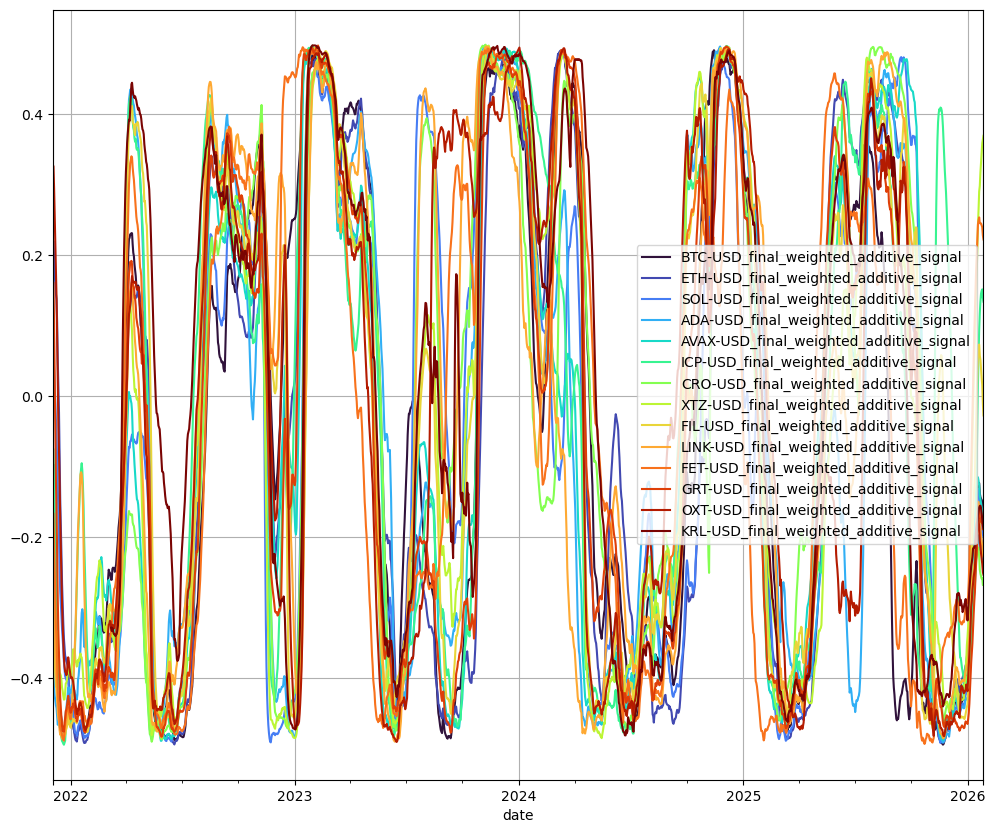

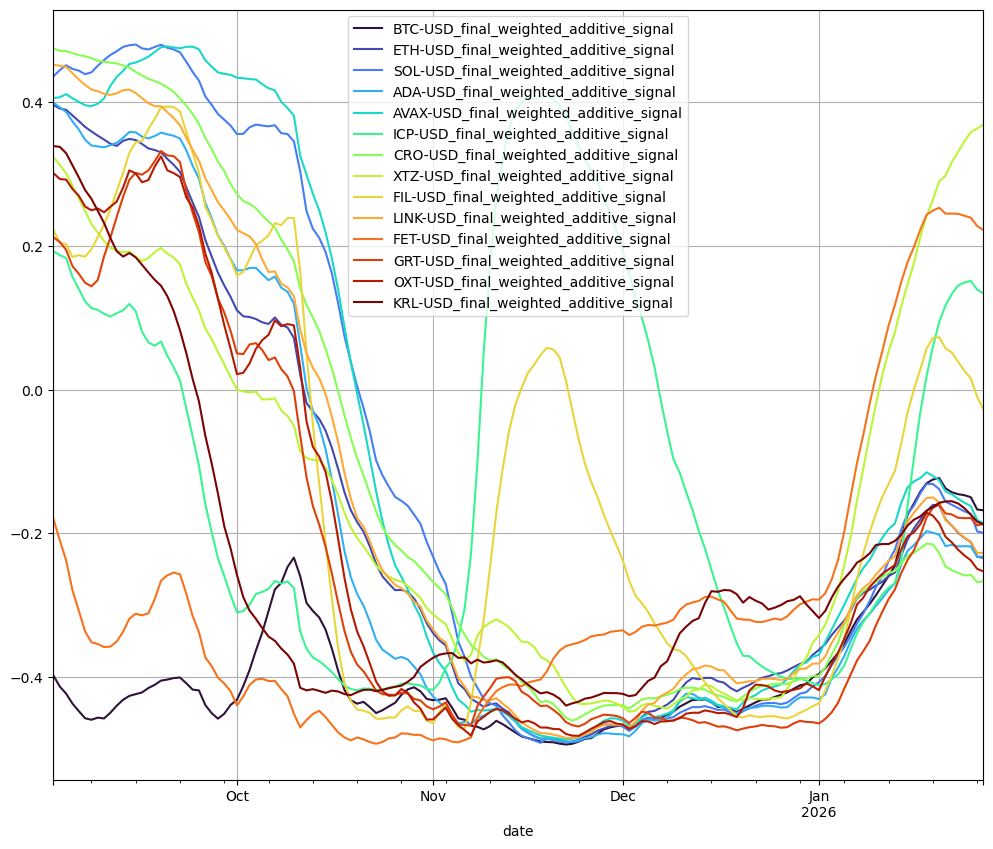

In [98]:
import matplotlib.pyplot as plt
import numpy as np

raw_signal_cols = [f'{t}_final_weighted_additive_signal' for t in ticker_list]
date_cond = df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01')

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(raw_signal_cols)))

df_expanded_universe_with_conditional_name_cap[raw_signal_cols].plot(figsize=(12,10), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, raw_signal_cols].plot(figsize=(12,10), grid=True, color=colors, linewidth=1.5)
plt.show()


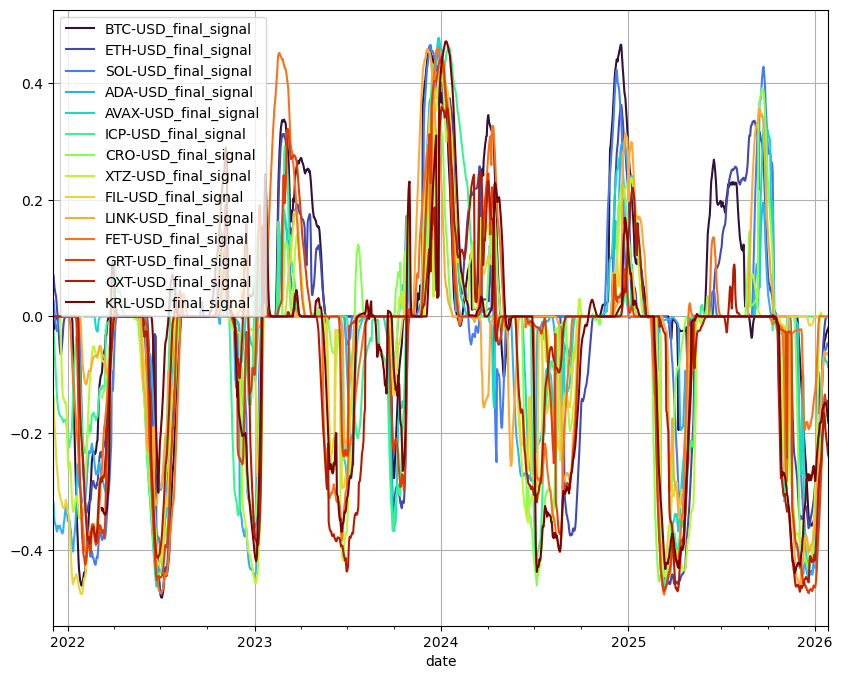

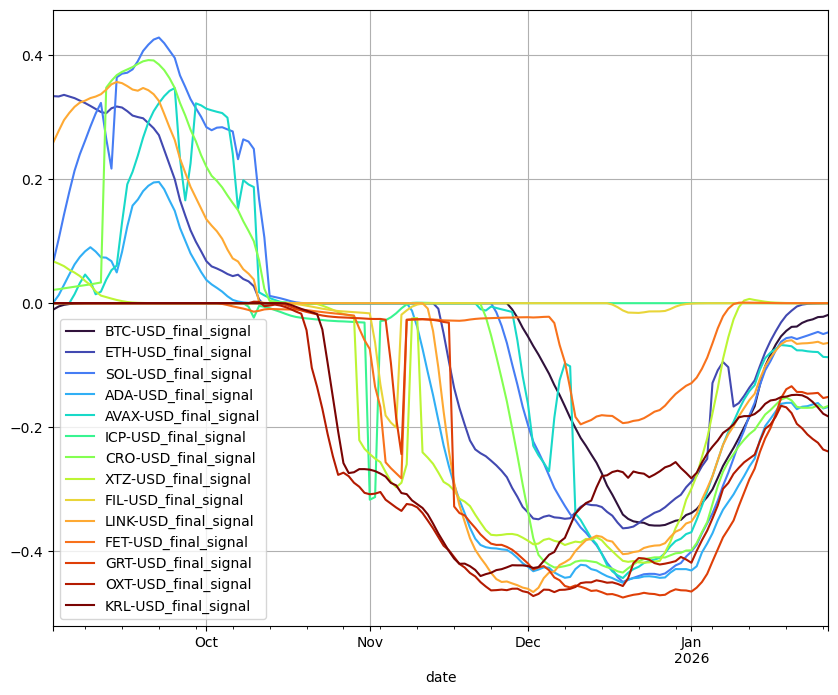

In [100]:
## Signal after Regime Filtering and Before Volatility Adjusting
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[final_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, final_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

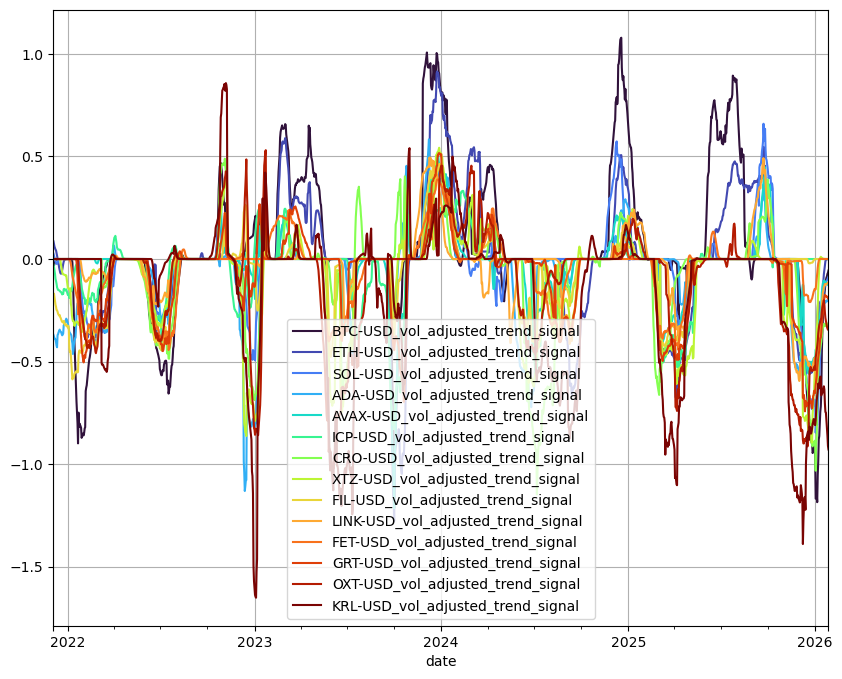

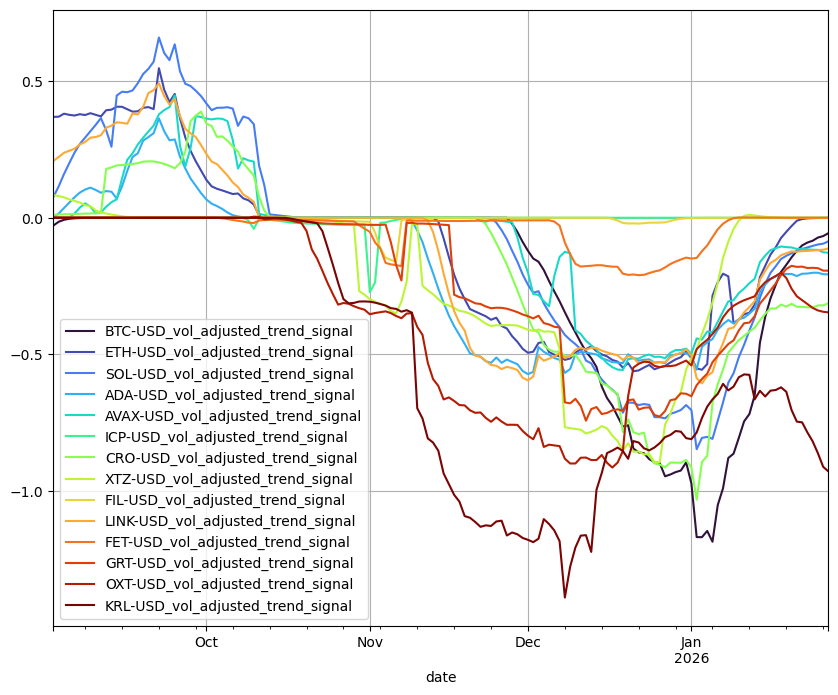

In [102]:
## Signal after Volatility Adjusting
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[vol_adj_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, vol_adj_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

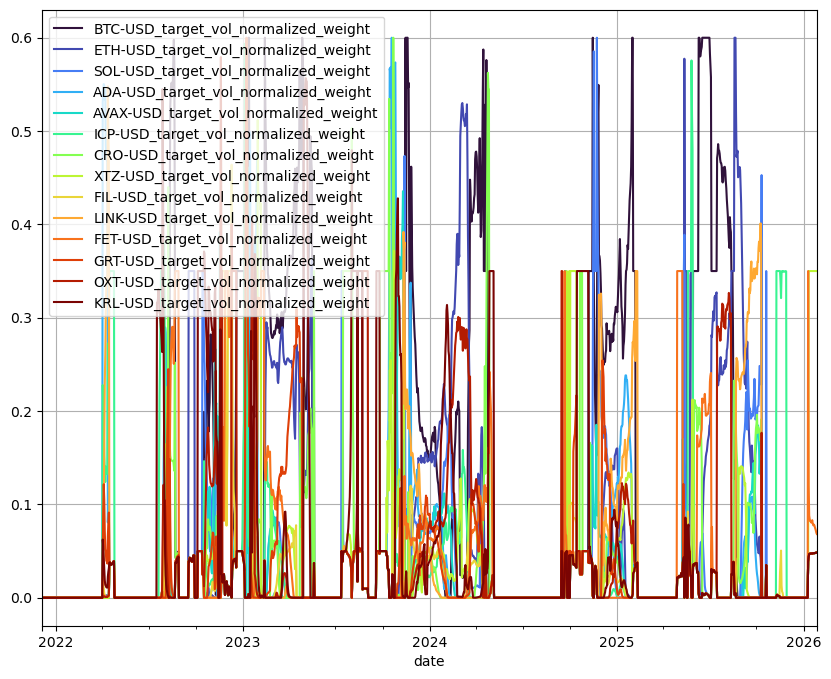

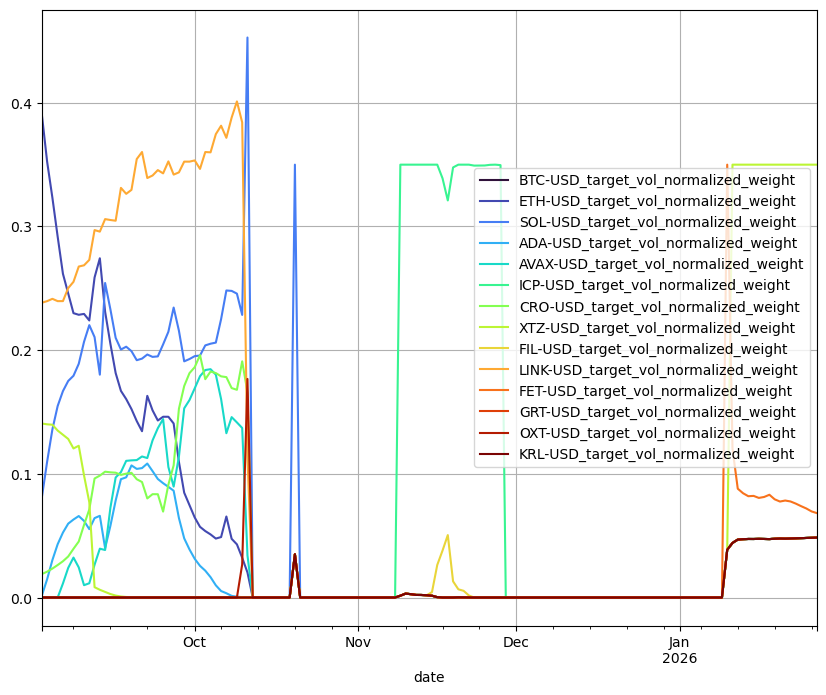

In [104]:
## Signal after Volatility Adjusting
target_vol_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[target_vol_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, target_vol_signal_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

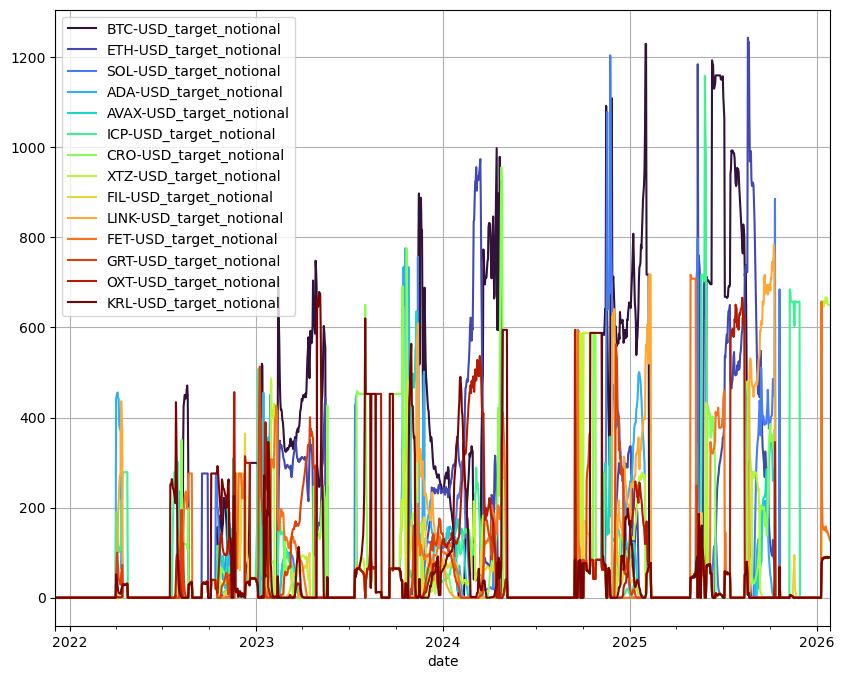

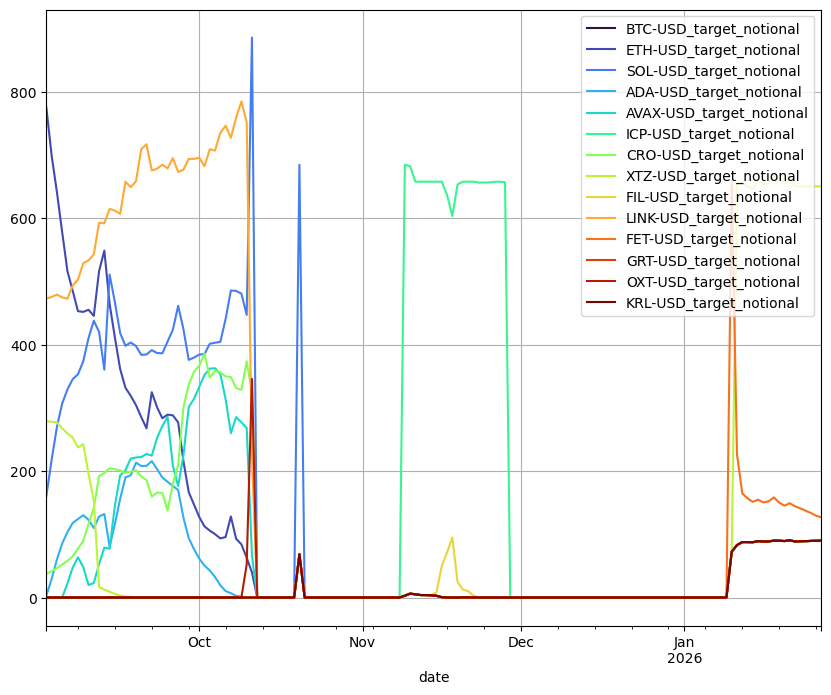

In [106]:
## Signal after Volatility Adjusting
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
date_cond = (df_expanded_universe_with_conditional_name_cap.index > pd.Timestamp('2025-09-01'))

cmap = plt.get_cmap("turbo")  # strong, high-contrast colors
colors = cmap(np.linspace(0, 1, len(final_signal_cols)))

df_expanded_universe_with_conditional_name_cap[target_notional_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
df_expanded_universe_with_conditional_name_cap.loc[date_cond, target_notional_cols].plot(figsize=(10,8), grid=True, color=colors, linewidth=1.5)
plt.show()

## Production Trend Following Signal

In [426]:
import scipy

def create_trend_strategy_log_space_prod(df, ticker, mavg_start, mavg_end, mavg_stepsize, mavg_z_score_window=252):

    df_working = df.copy()
    
    # ---- constants ----
    windows = np.geomspace(mavg_start, mavg_end, mavg_stepsize).round().astype(int)
    windows = np.unique(windows)
    x = np.log(windows[::-1])
    xm = x - x.mean()
    varx = (xm ** 2).sum()

    # ---- compute MAs (vectorised) ----
    df_working[f'{ticker}_t_1_close_log'] = np.log(df_working[f'{ticker}_t_1_close'])
    for w in windows:
        df_working[f'{ticker}_{w}_t_1_ema'] = df_working[f'{ticker}_t_1_close_log'].ewm(span=w, adjust=False).mean()

    mavg_mat = df_working[[f'{ticker}_{w}_t_1_ema' for w in windows]].to_numpy()

    # ---- slope (vectorised) ----
    slope = mavg_mat.dot(xm) / varx  # ndarray (T,)
    slope = pd.Series(slope, index=df_working.index)  # lag to avoid look-ahead

    # ---- z-score & rank ----
    z = ((slope - slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).mean()) /
         slope.rolling(mavg_z_score_window, min_periods=mavg_z_score_window).std())

    # Optional Tail Cap
    z = z.clip(-4, 4)

    # Calculate the Percentile Rank based on CDF
    rank = scipy.stats.norm.cdf(z) - 0.5  # centered 0 ↔ ±0.5

    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    df_working[trend_continuous_signal_col] = slope
    df_working[trend_continuous_signal_rank_col] = rank

    return df_working

In [428]:
def calculate_donchian_channel_dual_window_prod(df, ticker, entry_rolling_donchian_window=20, exit_rolling_donchian_window=20):

    df_working = df.copy()
    
    ## Entry Channel
    # Rolling maximum of returns (upper channel)
    df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band'] = (
        df_working[f'{ticker}_t_1_high'].rolling(window=entry_rolling_donchian_window).max())

    # Rolling minimum of returns (lower channel)
    df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band'] = (
        df_working[f'{ticker}_t_1_low'].rolling(window=entry_rolling_donchian_window).min())

    ## Exit Channel
    # Rolling maximum of returns (upper channel)
    df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band'] = (
        df_working[f'{ticker}_t_1_high'].rolling(window=exit_rolling_donchian_window).max())

    # Rolling minimum of returns (lower channel)
    df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band'] = (
        df_working[f'{ticker}_t_1_low'].rolling(window=exit_rolling_donchian_window).min())

    # Middle of the channel (optional, could be just average of upper and lower)
    # Entry Middle Band
    df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band'] = (
        (df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band'] +
         df_working[f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band']) / 2)

    # Exit Middle Band
    df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band'] = (
        (df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band'] +
         df_working[f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band']) / 2)

    return df_working

In [430]:
def calculate_rolling_r2_prod(df, ticker, t_1_close_price_col, rolling_r2_window=30, lower_r_sqr_limit=0.2,
                              upper_r_sqr_limit=0.8, r2_smooth_window=3):

    df_working = df.copy()
    log_price_col = f'{ticker}_t_1_close_price_log'
    df_working[log_price_col] = np.log(df_working[t_1_close_price_col])

    ## Define the variables
    y = df_working[log_price_col]
    x = np.arange(len(y), dtype=float)  # Time

    ## Compute rolling sums for rolling R2 calculation
    x_sum = pd.Series(x, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sum = y.rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    x_sqr = pd.Series(x ** 2, y.index).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    y_sqr = (y ** 2).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()
    xy_sum = pd.Series(x, y.index).mul(y).rolling(rolling_r2_window, min_periods=rolling_r2_window).sum()

    ## Calculate the R squared
    n = rolling_r2_window
    numerator = n * xy_sum - x_sum * y_sum
    denominator = np.sqrt((n * x_sqr) - (x_sum ** 2)) * np.sqrt((n * y_sqr) - (y_sum ** 2))
    df_working[f'{ticker}_rolling_r_sqr'] = (numerator / denominator) ** 2

    ## Normalize the R Squared centered around 0.5 where values below the lower limit are
    ## clipped to 0 and values above the upper limit are clipped to 1
    df_working[f'{ticker}_rolling_r_sqr'] = np.clip(
        (df_working[f'{ticker}_rolling_r_sqr'] - lower_r_sqr_limit) / (upper_r_sqr_limit - lower_r_sqr_limit),
        0, 1)

    ## Smoothing the Rolling R Squared Signal
    if r2_smooth_window >= 1:
        df_working[f'{ticker}_rolling_r_sqr'] = df_working[f'{ticker}_rolling_r_sqr'].ewm(span=r2_smooth_window, adjust=False).mean()

    return df_working

In [432]:
def generate_vol_of_vol_signal_log_space_prod(df, ticker, t_1_close_price_col, log_std_window=14,
                                              coef_of_variation_window=30, vol_of_vol_z_score_window=252,
                                              vol_of_vol_p_min=0.6):

    df_working = df.copy()
    log_returns_col = f'{ticker}_t_1_log_returns'
    realized_log_returns_vol = f'{ticker}_ann_log_volatility'
    df_working[log_returns_col] = np.log(df_working[t_1_close_price_col] / df_working[t_1_close_price_col].shift(1))
    eps = 1e-12

    ## Realized Volatility of Log Returns
    df_working[realized_log_returns_vol] = (
        df_working[log_returns_col].ewm(span=log_std_window, adjust=False,
                                        min_periods=log_std_window).std() * np.sqrt(365)
    )

    ## Coefficient of Variation in Volatility
    df_working[f'{ticker}_coef_variation_vol'] = (
            df_working[realized_log_returns_vol].rolling(coef_of_variation_window,
                                                         min_periods=coef_of_variation_window).std() /
            df_working[realized_log_returns_vol].rolling(coef_of_variation_window,
                                                         min_periods=coef_of_variation_window).mean().clip(lower=eps)
    )

    ## Calculate Robust Z-Score of the Coefficient of Variation
    cov_rolling_median = (
        df_working[f'{ticker}_coef_variation_vol'].rolling(vol_of_vol_z_score_window,
                                                   min_periods=vol_of_vol_z_score_window).median()
    )
    df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median'] = cov_rolling_median
    cov_rolling_mad = (
        (df_working[f'{ticker}_coef_variation_vol'] - df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']).abs()
        .rolling(vol_of_vol_z_score_window, min_periods=vol_of_vol_z_score_window).median()
    )
    df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev'] = cov_rolling_mad
    df_working[f'{ticker}_vol_of_vol_robust_z_score'] = (
        (df_working[f'{ticker}_coef_variation_vol'] - df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median']) /
        (1.4826 * df_working[f'{ticker}_cov_vol_rolling_{vol_of_vol_z_score_window}_median_abs_dev']).clip(lower=eps)
    )
    df_working[f'{ticker}_vol_of_vol_robust_z_score'] = (
        df_working[f'{ticker}_vol_of_vol_robust_z_score'].replace([np.inf, -np.inf], 0.0)
        .fillna(0.0).clip(lower=-3, upper=3)
    )

    ## Create Vol of Vol Thresholds
    ## z0 represents low volatility and z1 represents high volatility
    ## The vol of vol penalty will go from 1 to p_min where 1 represents no penalty
    z0, z1 = 0.5, 1.5                # z_vov below 0.5 → no penalty; above 1.5 → max raw penalty
    p_min = vol_of_vol_p_min         # even at max raw penalty, keep at least 60% exposure

    ## Compute a 0..1 raw penalty that rises from 0→1 as z_vov goes z0→z1
    df_working[f'{ticker}_vol_of_vol_signal_raw'] = (df_working[f'{ticker}_vol_of_vol_robust_z_score'] - z0) / max((z1 - z0), eps)

    ## Clip the signal to [0, 1]
    df_working[f'{ticker}_vol_of_vol_signal_raw'] = df_working[f'{ticker}_vol_of_vol_signal_raw'].clip(0, 1)

    ## Invert so that the raw penalty goes from 1 to 0 instead of 0 to 1
    df_working[f'{ticker}_vol_of_vol_penalty'] = 1 - df_working[f'{ticker}_vol_of_vol_signal_raw']

    ## Floor the penalty at p_min
    df_working[f'{ticker}_vol_of_vol_penalty'] = df_working[f'{ticker}_vol_of_vol_penalty'].clip(lower=p_min, upper=1)

    return df_working

In [460]:
def generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol_prod(
        start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, donchian_shift,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, long_only=False):

    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close', 'open', 'high', 'low', 'volume']].rename(
        columns={'close' : f'{ticker}_t_1_close',
                 'open'  : f'{ticker}_t_1_open',
                 'high'  : f'{ticker}_t_1_high',
                 'low'   : f'{ticker}_t_1_low',
                 'volume': f'{ticker}_t_1_volume'}))
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors="coerce", utc=False)
    date_cond = ((df.index.get_level_values('date') >= pd.Timestamp(start_date)) &
                 (df.index.get_level_values('date') <= pd.Timestamp(end_date)))
    df = df[date_cond].shift(1)

    # Create Column Names
    t_1_close_col = f'{ticker}_t_1_close'
    donchian_binary_signal_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_binary_signal'
    donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
    donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
    trend_binary_signal_col = f'{ticker}_trend_signal'
    trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
    trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
    final_binary_signal_col = f'{ticker}_final_binary_signal'
    final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
    final_signal_col = f'{ticker}_final_signal'

    ## Generate Trend Signal in Log Space
    df_trend = create_trend_strategy_log_space_prod(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg,
                                                    mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window)

    ## Generate Donchian Channels
    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian = calculate_donchian_channel_dual_window_prod(df, ticker=ticker,
                                                              entry_rolling_donchian_window=entry_rolling_donchian_window,
                                                              exit_rolling_donchian_window=exit_rolling_donchian_window)

    donchian_entry_upper_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_upper_band'
    donchian_entry_lower_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_lower_band'
    donchian_entry_middle_band_col = f'{ticker}_{entry_rolling_donchian_window}_donchian_entry_middle_band'
    donchian_exit_upper_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_upper_band'
    donchian_exit_lower_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_lower_band'
    donchian_exit_middle_band_col = f'{ticker}_{exit_rolling_donchian_window}_donchian_exit_middle_band'
    shift_cols = [donchian_entry_upper_band_col, donchian_entry_lower_band_col, donchian_entry_middle_band_col,
                  donchian_exit_upper_band_col, donchian_exit_lower_band_col, donchian_exit_middle_band_col]
    for col in shift_cols:
        df_donchian[f'{col}_t_1'] = df_donchian[col].shift(1)

    # Donchian Continuous Signal
    if donchian_shift:
        df_donchian[donchian_continuous_signal_col] = (
            (df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}_t_1']) /
            (df_donchian[f'{donchian_entry_upper_band_col}_t_1'] - df_donchian[f'{donchian_entry_lower_band_col}_t_1'])
        )
    else:
        df_donchian[donchian_continuous_signal_col] = (
            (df_donchian[t_1_close_col] - df_donchian[f'{donchian_entry_middle_band_col}']) /
            (df_donchian[f'{donchian_entry_upper_band_col}'] - df_donchian[f'{donchian_entry_lower_band_col}'])
        )

    ## Calculate Donchian Channel Rank
    ## Adjust the percentage ranks by 0.5 as without, the ranks go from 0 to 1. Recentering the function by giving it a steeper
    ## slope near the origin takes into account even little information
    df_donchian[donchian_continuous_signal_rank_col] = tf.pct_rank(df_donchian[donchian_continuous_signal_col]) - 0.5

    # Donchian Binary Signal
    if donchian_shift:
        gate_long_condition = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}_t_1']
        gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}_t_1']
    else:
        gate_long_condition = df_donchian[t_1_close_col] >= df_donchian[f'{donchian_exit_lower_band_col}']
        gate_short_condition = df_donchian[t_1_close_col] <= df_donchian[f'{donchian_exit_upper_band_col}']
    # sign of *entry* score decides direction
    entry_sign = np.sign(df_donchian[donchian_continuous_signal_col])
    # treat exact zero as "flat but allowed" (gate=1) so ranking not wiped out
    entry_sign = np.where(entry_sign == 0, 1, entry_sign)  # default to long-side keep
    df_donchian[donchian_binary_signal_col] = np.where(
        entry_sign > 0, gate_long_condition, gate_short_condition).astype(float)

    # Merging the Trend and Donchian Dataframes
    if donchian_shift:
        donchian_cols = [f'{donchian_entry_upper_band_col}_t_1', f'{donchian_entry_lower_band_col}_t_1',
                         f'{donchian_entry_middle_band_col}_t_1', f'{donchian_exit_upper_band_col}_t_1',
                         f'{donchian_exit_lower_band_col}_t_1', f'{donchian_exit_middle_band_col}_t_1',
                         donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    else:
        donchian_cols = [f'{donchian_entry_upper_band_col}', f'{donchian_entry_lower_band_col}',
                         f'{donchian_entry_middle_band_col}', f'{donchian_exit_upper_band_col}',
                         f'{donchian_exit_lower_band_col}', f'{donchian_exit_middle_band_col}',
                         donchian_binary_signal_col, donchian_continuous_signal_col, donchian_continuous_signal_rank_col]
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')

    ## Trend and Donchian Channel Signal
    # Calculate the exponential weighted average of the ranked signals to remove short-term flip-flops (whiplash)
    df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]] = (
        df_trend[[trend_continuous_signal_rank_col, donchian_continuous_signal_rank_col]].ewm(
            span=weighted_signal_ewm_window, adjust=False).mean())

    # Weighted Sum of Rank Columns
    df_trend[final_weighted_additive_signal_col] = (
                ma_crossover_signal_weight * df_trend[trend_continuous_signal_rank_col] +
                donchian_signal_weight * df_trend[donchian_continuous_signal_rank_col])

    # Apply Binary Gate
    if use_donchian_exit_gate:
        df_trend[final_weighted_additive_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[
            donchian_binary_signal_col]

    ## Calculate Rolling R Squared Signal
    df_trend = calculate_rolling_r2_prod(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col,
                                         rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
                                         upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window)

    ## Calculate Vol of Vol Signal
    df_trend = generate_vol_of_vol_signal_log_space_prod(df_trend, ticker=ticker, t_1_close_price_col=t_1_close_col,
                                                         log_std_window=log_std_window,
                                                         coef_of_variation_window=coef_of_variation_window,
                                                         vol_of_vol_z_score_window=vol_of_vol_z_score_window,
                                                         vol_of_vol_p_min=vol_of_vol_p_min)

    ## Apply Regime Filters
    strong_rolling_r_sqr_cond = (df_trend[f'{ticker}_rolling_r_sqr'] >= r2_strong_threshold)
    df_trend[f'{ticker}_regime_filter'] = (
        np.where(strong_rolling_r_sqr_cond, df_trend[f'{ticker}_rolling_r_sqr'],
                 df_trend[f'{ticker}_rolling_r_sqr'] * df_trend[f'{ticker}_vol_of_vol_penalty']).astype(float)
    )
    df_trend[final_signal_col] = df_trend[final_weighted_additive_signal_col] * df_trend[f'{ticker}_regime_filter']

    # Introduce a Confirmation period for Rolling R Squared Signal
    if r2_confirm_days >= 1:
        df_trend[f'{ticker}_r2_enable'] = (
            (df_trend[f'{ticker}_rolling_r_sqr'] > 0.5).rolling(r2_confirm_days, min_periods=r2_confirm_days).min()
            .fillna(0.0).astype(float)
        )
        df_trend[final_signal_col] = df_trend[final_signal_col] * df_trend[f'{ticker}_r2_enable']
    else:
        df_trend[final_signal_col] = df_trend[final_signal_col]

    ## Long-Only Filter
    df_trend[final_signal_col] = np.where(long_only, np.maximum(0, df_trend[final_signal_col]),
                                          df_trend[final_signal_col])

    return df_trend

In [492]:
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_prod(
    start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
    entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate, donchian_shift,
    ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
    rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
    log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
    r2_strong_threshold=0.8, long_only=False):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        close_price_col = f'{ticker}_t_1_close'
        open_price_col = f'{ticker}_t_1_open'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        vol_of_vol_penalty_col = f'{ticker}_vol_of_vol_penalty'
        regime_filter_col = f'{ticker}_regime_filter'
        # rolling_r2_enable_col = f'{ticker}_r2_enable'
        final_signal_col = f'{ticker}_final_signal'

        if pd.to_datetime(date_list[ticker]).date() > start_date:
            run_date = pd.to_datetime(date_list[ticker]).date()
        else:
            run_date = start_date

        df_trend = generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol_prod(
            start_date=run_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window,
            use_donchian_exit_gate=use_donchian_exit_gate, donchian_shift=donchian_shift,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold, long_only=long_only)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      final_weighted_additive_signal_col, rolling_r2_col, vol_of_vol_penalty_col,
                      regime_filter_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [528]:
# Below we calculate the number of risk units deployed per ticker per day
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal_continuous_prod(df, ticker_list, volatility_window, annual_trading_days=365):

    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        close_price_col = f'{ticker}_t_1_close'
        open_price_col = f'{ticker}_t_1_open'
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        donchian_continuous_signal_col = f'{ticker}_donchian_continuous_signal'
        donchian_continuous_signal_rank_col = f'{ticker}_donchian_continuous_signal_rank'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        vol_of_vol_penalty_col = f'{ticker}_vol_of_vol_penalty'
        regime_filter_col = f'{ticker}_regime_filter'
        # rolling_r2_enable_col = f'{ticker}_r2_enable'
        final_signal_col = f'{ticker}_final_signal'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'

        ## Calculate Position Volatility Adjusted Trend Signal
        # df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}_t_1_close')
        df[annualized_volatility_col] = (df[f'{ticker}_t_1_close_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[final_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        trend_cols = [close_price_col, open_price_col, f'{ticker}_t_1_close_pct_returns',
                      trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      donchian_continuous_signal_col, donchian_continuous_signal_rank_col,
                      final_weighted_additive_signal_col, rolling_r2_col, vol_of_vol_penalty_col,
                      regime_filter_col, final_signal_col, annualized_volatility_col,
                      vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    return df_signal

In [494]:
end_date = utc_now().date()
start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

In [496]:
start_date

datetime.date(2025, 4, 4)

In [498]:
cfg = load_prod_strategy_config(strategy_version='v0.2.0')

# Build kwargs directly from cfg sections
sig_kwargs = {
    # Dates
    "start_date": start_date,
    "end_date": end_date,

    # Universe
    "ticker_list": cfg["universe"]["tickers"],

    # Moving Average Signal
    "fast_mavg": cfg["signals"]["moving_average"]["fast_mavg"],
    "slow_mavg": cfg["signals"]["moving_average"]["slow_mavg"],
    "mavg_stepsize": cfg["signals"]["moving_average"]["mavg_stepsize"],
    "mavg_z_score_window": cfg["signals"]["moving_average"]["mavg_z_score_window"],

    # Donchain Channel Signal
    "entry_rolling_donchian_window": cfg["signals"]["donchian"]["entry_rolling_donchian_window"],
    "exit_rolling_donchian_window": cfg["signals"]["donchian"]["exit_rolling_donchian_window"],
    "use_donchian_exit_gate": cfg["signals"]["donchian"]["use_donchian_exit_gate"],

    # Signal Weights
    "ma_crossover_signal_weight": cfg["signals"]["weighting"]["ma_crossover_signal_weight"],
    "donchian_signal_weight": cfg["signals"]["weighting"]["donchian_signal_weight"],
    "weighted_signal_ewm_window": cfg["signals"]["weighting"]["weighted_signal_ewm_window"],
    "rolling_r2_window": cfg["signals"]["filters"]["rolling_r2"]["rolling_r2_window"],

    # Rolling R Squared Filter
    "lower_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["lower_r_sqr_limit"],
    "upper_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["upper_r_sqr_limit"],
    "r2_smooth_window": cfg["signals"]["filters"]["rolling_r2"]["r2_smooth_window"],
    "r2_confirm_days": cfg["signals"]["filters"]["rolling_r2"]["r2_confirm_days"],

    # Vol of Vol Filter
    "log_std_window": cfg["signals"]["filters"]["vol_of_vol"]["log_std_window"],
    "coef_of_variation_window": cfg["signals"]["filters"]["vol_of_vol"]["coef_of_variation_window"],
    "vol_of_vol_z_score_window": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_z_score_window"],
    "vol_of_vol_p_min": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_p_min"],
    "r2_strong_threshold": cfg["signals"]["filters"]["rolling_r2"]["r2_strong_threshold"],

    # Signal & Data Parameters
    # "use_activation": cfg["signals"]["activation"]["use_activation"],
    # "tanh_activation_constant_dict": cfg["signals"]["activation"]["tanh_activation_constant_dict"],
    # "moving_avg_type": cfg["data"]["moving_avg_type"],
    "long_only": cfg["run"]["long_only"],
    # "price_or_returns_calc": cfg["data"]["price_or_returns_calc"],
    # "use_coinbase_data": cfg["data"]["use_coinbase_data"],
    # "use_saved_files": False,
    # "saved_file_end_date": None  # cfg["data"]["saved_file_end_date"]

    "donchian_shift": True
}

df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol_prod(**sig_kwargs)

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.2.0-live/config/trend_strategy_config_v0.2.0.yaml
True


In [530]:
df_signal = get_volatility_adjusted_trend_signal_continuous_prod(
    df_trend,
    ticker_list=cfg['universe']['tickers'],
    volatility_window=cfg['risk_and_sizing']['volatility_window'],
    annual_trading_days=cfg['run']['annual_trading_days']
)

In [480]:
## Original Signal
end_date = utc_now().date()
start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

# Build kwargs directly from cfg sections
sig_kwargs = {
    # Dates
    "start_date": start_date,
    "end_date": end_date,

    # Universe
    "ticker_list": cfg["universe"]["tickers"],

    # Moving Average Signal
    "fast_mavg": cfg["signals"]["moving_average"]["fast_mavg"],
    "slow_mavg": cfg["signals"]["moving_average"]["slow_mavg"],
    "mavg_stepsize": cfg["signals"]["moving_average"]["mavg_stepsize"],
    "mavg_z_score_window": cfg["signals"]["moving_average"]["mavg_z_score_window"],

    # Donchain Channel Signal
    "entry_rolling_donchian_window": cfg["signals"]["donchian"]["entry_rolling_donchian_window"],
    "exit_rolling_donchian_window": cfg["signals"]["donchian"]["exit_rolling_donchian_window"],
    "use_donchian_exit_gate": cfg["signals"]["donchian"]["use_donchian_exit_gate"],

    # Signal Weights
    "ma_crossover_signal_weight": cfg["signals"]["weighting"]["ma_crossover_signal_weight"],
    "donchian_signal_weight": cfg["signals"]["weighting"]["donchian_signal_weight"],
    "weighted_signal_ewm_window": cfg["signals"]["weighting"]["weighted_signal_ewm_window"],
    "rolling_r2_window": cfg["signals"]["filters"]["rolling_r2"]["rolling_r2_window"],

    # Rolling R Squared Filter
    "lower_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["lower_r_sqr_limit"],
    "upper_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["upper_r_sqr_limit"],
    "r2_smooth_window": cfg["signals"]["filters"]["rolling_r2"]["r2_smooth_window"],
    "r2_confirm_days": cfg["signals"]["filters"]["rolling_r2"]["r2_confirm_days"],

    # Vol of Vol Filter
    "log_std_window": cfg["signals"]["filters"]["vol_of_vol"]["log_std_window"],
    "coef_of_variation_window": cfg["signals"]["filters"]["vol_of_vol"]["coef_of_variation_window"],
    "vol_of_vol_z_score_window": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_z_score_window"],
    "vol_of_vol_p_min": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_p_min"],
    "r2_strong_threshold": cfg["signals"]["filters"]["rolling_r2"]["r2_strong_threshold"],

    # Signal & Data Parameters
    "use_activation": cfg["signals"]["activation"]["use_activation"],
    "tanh_activation_constant_dict": cfg["signals"]["activation"]["tanh_activation_constant_dict"],
    "moving_avg_type": cfg["data"]["moving_avg_type"],
    "long_only": cfg["run"]["long_only"],
    "price_or_returns_calc": cfg["data"]["price_or_returns_calc"],
    "use_coinbase_data": cfg["data"]["use_coinbase_data"],
    "use_saved_files": False,
    "saved_file_end_date": None  # cfg["data"]["saved_file_end_date"]
}

df_trend_orig = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(**sig_kwargs)

In [516]:
df_signal_orig = size_cont.get_volatility_adjusted_trend_signal_continuous(
    df_trend_orig,
    ticker_list=cfg['universe']['tickers'],
    volatility_window=cfg['risk_and_sizing']['volatility_window'],
    annual_trading_days=cfg['run']['annual_trading_days']
)

In [518]:
df_trend.tail()

BTC-USD_t_1_close  BTC-USD_t_1_open  BTC-USD_mavg_ribbon_slope  \
date                                                                         
2026-01-25           89082.17          89474.94                  -0.034630   
2026-01-26           86561.94          89082.16                  -0.036026   
2026-01-27           88250.01          86561.94                  -0.036572   
2026-01-28           89116.96          88250.00                  -0.036684   
2026-01-29           89162.40          89116.96                  -0.036731   

            BTC-USD_mavg_ribbon_rank  BTC-USD_donchian_continuous_signal  \
date                                                                       
2026-01-25                 -0.158534                           -0.127061   
2026-01-26                 -0.161844                           -0.304998   
2026-01-27                 -0.164248                           -0.185814   
2026-01-28                 -0.164428                           -0.152234   
2026-01-29                 -0.163010                           -0.148884   

            BTC-USD_donchian_continuous_signal_rank  \
date                                                  
2026-01-25                                -0.021931   
2026-01-26                                -0.149224   
2026-01-27                                -0.135436   
2026-01-28                                -0.110770   
2026-01-29                                -0.092691   

            BTC-USD_final_weighted_additive_signal  BTC-USD_rolling_r_sqr  \
date                                                                        
2026-01-25                               -0.138043               0.149894   
2026-01-26                               -0.159951               0.131150   
2026-01-27                               -0.159926               0.111402   
2026-01-28                               -0.156379               0.086753   
2026-01-29                               -0.152462               0.057415   

            BTC-USD_vol_of_vol_penalty  BTC-USD_regime_filter  \
date                                                            
2026-01-25                         1.0               0.149894   
2026-01-26                         1.0               0.131150   
2026-01-27                         1.0               0.111402   
2026-01-28                         1.0               0.086753   
2026-01-29                         1.0               0.057415   

            BTC-USD_final_signal  ETH-USD_t_1_close  ETH-USD_t_1_open  \
date                                                                    
2026-01-25                   0.0            2948.86           2952.76   
2026-01-26                   0.0            2814.28           2948.85   
2026-01-27                   0.0            2926.85           2814.19   
2026-01-28                   0.0            3021.91           2926.89   
2026-01-29                   0.0            3006.17           3021.90   

            ETH-USD_mavg_ribbon_slope  ETH-USD_mavg_ribbon_rank  \
date                                                              
2026-01-25                  -0.021686                 -0.242051   
2026-01-26                  -0.024727                 -0.247539   
2026-01-27                  -0.026069                 -0.251761   
2026-01-28                  -0.026128                 -0.252974   
2026-01-29                  -0.026340                 -0.252645   

            ETH-USD_donchian_continuous_signal  \
date                                             
2026-01-25                           -0.194933   
2026-01-26                           -0.371868   
2026-01-27                           -0.223870   
2026-01-28                           -0.147041   
2026-01-29                           -0.169399   

            ETH-USD_donchian_continuous_signal_rank  \
date                                                  
2026-01-25                                -0.186217   
2026-01-26                                -0.283862 

In [481]:
df_trend_orig.tail()

BTC-USD_close  BTC-USD_open  BTC-USD_mavg_ribbon_slope  \
date                                                                 
2026-01-25       86561.94      89082.16                  -0.034630   
2026-01-26       88250.01      86561.94                  -0.036026   
2026-01-27       89116.96      88250.00                  -0.036572   
2026-01-28       89162.40      89116.96                  -0.036684   
2026-01-29       87882.97      89162.40                  -0.036731   

            BTC-USD_mavg_ribbon_rank  BTC-USD_donchian_continuous_signal  \
date                                                                       
2026-01-25                 -0.158534                           -0.127061   
2026-01-26                 -0.161844                           -0.304998   
2026-01-27                 -0.164248                           -0.185814   
2026-01-28                 -0.164428                           -0.152234   
2026-01-29                 -0.163010                           -0.148884   

            BTC-USD_donchian_continuous_signal_rank  \
date                                                  
2026-01-25                                -0.021931   
2026-01-26                                -0.149224   
2026-01-27                                -0.135436   
2026-01-28                                -0.110770   
2026-01-29                                -0.092691   

            BTC-USD_final_weighted_additive_signal  BTC-USD_rolling_r_sqr  \
date                                                                        
2026-01-25                               -0.138043               0.149894   
2026-01-26                               -0.159951               0.131150   
2026-01-27                               -0.159926               0.111402   
2026-01-28                               -0.156379               0.086753   
2026-01-29                               -0.152462               0.057415   

            BTC-USD_vol_of_vol_penalty  BTC-USD_regime_filter  \
date                                                            
2026-01-25                         1.0               0.149894   
2026-01-26                         1.0               0.131150   
2026-01-27                         1.0               0.111402   
2026-01-28                         1.0               0.086753   
2026-01-29                         1.0               0.057415   

            BTC-USD_final_signal  ETH-USD_close  ETH-USD_open  \
date                                                            
2026-01-25                   0.0        2814.28       2948.85   
2026-01-26                   0.0        2926.85       2814.19   
2026-01-27                   0.0        3021.91       2926.89   
2026-01-28                   0.0        3006.17       3021.90   
2026-01-29                   0.0        2927.16       3006.17   

            ETH-USD_mavg_ribbon_slope  ETH-USD_mavg_ribbon_rank  \
date                                                              
2026-01-25                  -0.021686                 -0.242051   
2026-01-26                  -0.024727                 -0.247539   
2026-01-27                  -0.026069                 -0.251761   
2026-01-28                  -0.026128                 -0.252974   
2026-01-29                  -0.026340                 -0.252645   

            ETH-USD_donchian_continuous_signal  \
date                                             
2026-01-25                           -0.194933   
2026-01-26                           -0.371868   
2026-01-27                           -0.223870   
2026-01-28                           -0.147041   
2026-01-29                           -0.169399   

            ETH-USD_donchian_continuous_signal_rank  \
date                                                  
2026-01-25                                -0.186217   
2026-01-26                                -0.283862   
2026-01-27                                -0.275235   
2026-01-28                                -0.230715   

In [532]:
df_signal.tail()

BTC-USD_t_1_close  BTC-USD_t_1_open  \
date                                              
2026-01-25           89082.17          89474.94   
2026-01-26           86561.94          89082.16   
2026-01-27           88250.01          86561.94   
2026-01-28           89116.96          88250.00   
2026-01-29           89162.40          89116.96   

            BTC-USD_t_1_close_pct_returns  BTC-USD_mavg_ribbon_slope  \
date                                                                   
2026-01-25                      -0.004390                  -0.034630   
2026-01-26                      -0.028291                  -0.036026   
2026-01-27                       0.019501                  -0.036572   
2026-01-28                       0.009824                  -0.036684   
2026-01-29                       0.000510                  -0.036731   

            BTC-USD_mavg_ribbon_rank  BTC-USD_donchian_continuous_signal  \
date                                                                       
2026-01-25                 -0.158534                           -0.127061   
2026-01-26                 -0.161844                           -0.304998   
2026-01-27                 -0.164248                           -0.185814   
2026-01-28                 -0.164428                           -0.152234   
2026-01-29                 -0.163010                           -0.148884   

            BTC-USD_donchian_continuous_signal_rank  \
date                                                  
2026-01-25                                -0.021931   
2026-01-26                                -0.149224   
2026-01-27                                -0.135436   
2026-01-28                                -0.110770   
2026-01-29                                -0.092691   

            BTC-USD_final_weighted_additive_signal  BTC-USD_rolling_r_sqr  \
date                                                                        
2026-01-25                               -0.138043               0.149894   
2026-01-26                               -0.159951               0.131150   
2026-01-27                               -0.159926               0.111402   
2026-01-28                               -0.156379               0.086753   
2026-01-29                               -0.152462               0.057415   

            BTC-USD_vol_of_vol_penalty  BTC-USD_regime_filter  \
date                                                            
2026-01-25                         1.0               0.149894   
2026-01-26                         1.0               0.131150   
2026-01-27                         1.0               0.111402   
2026-01-28                         1.0               0.086753   
2026-01-29                         1.0               0.057415   

            BTC-USD_final_signal  BTC-USD_annualized_volatility_30  \
date                                                                 
2026-01-25                   0.0                          0.310051   
2026-01-26                   0.0                          0.326260   
2026-01-27                   0.0                          0.332820   
2026-01-28                   0.0                          0.334470   
2026-01-29                   0.0                          0.332772   

            BTC-USD_vol_adjusted_trend_signal  ETH-USD_t_1_close  \
date                                                               
2026-01-25                                0.0            2948.86   
2026-01-26                                0.0            2814.28   
2026-01-27                                0.0            2926.85   
2026-01-28                                0.0            3021.91   
2026-01-29                                0.0            3006.17   

            ETH-USD_t_1_open  ETH-USD_t_1_close_pct_returns  \
date                                                          
2026-01-25           2952.76                      -0.001324   
2026-01-26           2948.85                      -0.045638   
2026-01-27    

In [522]:
df_signal_orig.tail()

BTC-USD_close  BTC-USD_open  BTC-USD_t_1_close  \
date                                                         
2026-01-25       86561.94      89082.16           89082.17   
2026-01-26       88250.01      86561.94           86561.94   
2026-01-27       89116.96      88250.00           88250.01   
2026-01-28       89162.40      89116.96           89116.96   
2026-01-29       87882.97      89162.40           89162.40   

            BTC-USD_t_1_close_pct_returns  BTC-USD_final_signal  \
date                                                              
2026-01-25                      -0.004390                   0.0   
2026-01-26                      -0.028291                   0.0   
2026-01-27                       0.019501                   0.0   
2026-01-28                       0.009824                   0.0   
2026-01-29                       0.000510                   0.0   

            BTC-USD_final_weighted_additive_signal  \
date                                                 
2026-01-25                               -0.138043   
2026-01-26                               -0.159951   
2026-01-27                               -0.159926   
2026-01-28                               -0.156379   
2026-01-29                               -0.152462   

            BTC-USD_annualized_volatility_30  \
date                                           
2026-01-25                          0.310051   
2026-01-26                          0.326260   
2026-01-27                          0.332820   
2026-01-28                          0.334470   
2026-01-29                          0.332772   

            BTC-USD_vol_adjusted_trend_signal  ETH-USD_close  ETH-USD_open  \
date                                                                         
2026-01-25                                0.0        2814.28       2948.85   
2026-01-26                                0.0        2926.85       2814.19   
2026-01-27                                0.0        3021.91       2926.89   
2026-01-28                                0.0        3006.17       3021.90   
2026-01-29                                0.0        2927.16       3006.17   

            ETH-USD_t_1_close  ETH-USD_t_1_close_pct_returns  \
date                                                           
2026-01-25            2948.86                      -0.001324   
2026-01-26            2814.28                      -0.045638   
2026-01-27            2926.85                       0.040000   
2026-01-28            3021.91                       0.032479   
2026-01-29            3006.17                      -0.005209   

            ETH-USD_final_signal  ETH-USD_final_weighted_additive_signal  \
date                                                                       
2026-01-25                   0.0                               -0.233676   
2026-01-26                   0.0                               -0.252987   
2026-01-27                   0.0                               -0.255282   
2026-01-28                   0.0                               -0.249635   
2026-01-29                   0.0                               -0.246578   

            ETH-USD_annualized_volatility_30  \
date                                           
2026-01-25                          0.486615   
2026-01-26                          0.512004   
2026-01-27                          0.530992   
2026-01-28                          0.542844   
2026-01-29                          0.542875   

            ETH-USD_vol_adjusted_trend_signal  SOL-USD_close  SOL-USD_open  \
date                                                                         
2026-01-25                                0.0         118.73        127.02   
2026-01-26                                0.0         124.09        118.73   
2026-01-27                                0.0         127.02        124.09   
2026-01-28                                0.0         125.16        127.02   
2026-01-29                                0.0         122

In [446]:
# Pull Close Prices from Coinbase
df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                    end_date=end_date, save_to_file=False)
df = (df[['close', 'open', 'high', 'low', 'volume']].rename(
    columns={'close' : f'{ticker}_t_1_close',
             'open'  : f'{ticker}_t_1_open',
             'high'  : f'{ticker}_t_1_high',
             'low'   : f'{ticker}_t_1_low',
             'volume': f'{ticker}_t_1_volume'}))
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=False)
date_cond = ((df.index.get_level_values('date') >= pd.Timestamp(start_date)) &
             (df.index.get_level_values('date') <= pd.Timestamp(end_date)))


In [452]:
df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date,
                                                    end_date=end_date, save_to_file=False)
df = (df[['close', 'open', 'high', 'low', 'volume']].rename(
    columns={'close' : f'{ticker}_t_1_close',
             'open'  : f'{ticker}_t_1_open',
             'high'  : f'{ticker}_t_1_high',
             'low'   : f'{ticker}_t_1_low',
             'volume': f'{ticker}_t_1_volume'}))
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, errors="coerce", utc=False)
date_cond = ((df.index.get_level_values('date') >= pd.Timestamp(start_date)) &
             (df.index.get_level_values('date') <= pd.Timestamp(end_date)))
df = df[date_cond].shift(1)

In [454]:
df.tail()

XTZ-USD_t_1_close  XTZ-USD_t_1_open  XTZ-USD_t_1_high  \
date                                                                
2026-01-25             0.5844            0.5879            0.5902   
2026-01-26             0.5621            0.5848            0.5921   
2026-01-27             0.5651            0.5615            0.5852   
2026-01-28             0.5685            0.5647            0.5755   
2026-01-29             0.5362            0.5695            0.5705   

            XTZ-USD_t_1_low  XTZ-USD_t_1_volume  
date                                             
2026-01-25           0.5709           768879.44  
2026-01-26           0.5567          1535159.15  
2026-01-27           0.5589          1321506.57  
2026-01-28           0.5493          1321157.70  
2026-01-29           0.5350           922531.13

In [448]:
df.tail()

XTZ-USD_t_1_close  XTZ-USD_t_1_open  XTZ-USD_t_1_high  \
date                                                                
2026-01-25             0.5621            0.5848            0.5921   
2026-01-26             0.5651            0.5615            0.5852   
2026-01-27             0.5685            0.5647            0.5755   
2026-01-28             0.5362            0.5695            0.5705   
2026-01-29             0.5269            0.5361            0.5371   

            XTZ-USD_t_1_low  XTZ-USD_t_1_volume  
date                                             
2026-01-25           0.5567          1535159.15  
2026-01-26           0.5589          1321506.57  
2026-01-27           0.5493          1321157.70  
2026-01-28           0.5350           922531.13  
2026-01-29           0.5165           884680.57